In [2]:
import numpy as np

In [127]:
#wm vectors

n = 8
w_m_j = lambda m,j,n:np.sin(m*j*np.pi/n)
lambda_m = lambda m : np.cos(m*np.pi/n)

#matrix of w(m*n)
w = np.array([[w_m_j(m,j,n) for j in range(1, n)] for m in range(1, n)])
print(w)

#eigen values of each m :
lambda_vec = np.array([lambda_m(i) for i in range(1,n)])
print("quasi-eigenvalues = ",lambda_vec)
print("quasi-spectral_radius = ",np.amax(np.absolute(lambda_vec)))

[[ 3.82683432e-01  7.07106781e-01  9.23879533e-01  1.00000000e+00
   9.23879533e-01  7.07106781e-01  3.82683432e-01]
 [ 7.07106781e-01  1.00000000e+00  7.07106781e-01  1.22464680e-16
  -7.07106781e-01 -1.00000000e+00 -7.07106781e-01]
 [ 9.23879533e-01  7.07106781e-01 -3.82683432e-01 -1.00000000e+00
  -3.82683432e-01  7.07106781e-01  9.23879533e-01]
 [ 1.00000000e+00  1.22464680e-16 -1.00000000e+00 -2.44929360e-16
   1.00000000e+00  3.67394040e-16 -1.00000000e+00]
 [ 9.23879533e-01 -7.07106781e-01 -3.82683432e-01  1.00000000e+00
  -3.82683432e-01 -7.07106781e-01  9.23879533e-01]
 [ 7.07106781e-01 -1.00000000e+00  7.07106781e-01  3.67394040e-16
  -7.07106781e-01  1.00000000e+00 -7.07106781e-01]
 [ 3.82683432e-01 -7.07106781e-01  9.23879533e-01 -1.00000000e+00
   9.23879533e-01 -7.07106781e-01  3.82683432e-01]]
quasi-eigenvalues =  [ 9.23879533e-01  7.07106781e-01  3.82683432e-01  6.12323400e-17
 -3.82683432e-01 -7.07106781e-01 -9.23879533e-01]
quasi-spectral_radius =  0.9238795325112867


In [128]:
#m==k:
for i in range(1, n-1):
    print("m=",i, ", w_m*w_m=",np.dot(w[i], w[i]))

m= 1 , w_m*w_m= 4.0
m= 2 , w_m*w_m= 4.0
m= 3 , w_m*w_m= 4.0
m= 4 , w_m*w_m= 4.000000000000001
m= 5 , w_m*w_m= 4.000000000000002
m= 6 , w_m*w_m= 3.9999999999999982


In [129]:
#m!=k:
np.dot(w[0], w[1])

1.1102230246251565e-16

In [141]:
cos_arr = np.array([np.cos((2*i*np.pi)/n) for i in range(1, n)])
print(cos_arr, sum(cos_arr))

[ 7.07106781e-01  6.12323400e-17 -7.07106781e-01 -1.00000000e+00
 -7.07106781e-01 -1.83697020e-16  7.07106781e-01] -1.0000000000000004


2.547805770663616e-09 2.547805770663616e-09
2.547805770663616e-09 1.3007464505896799e-09
1.9587259065812517


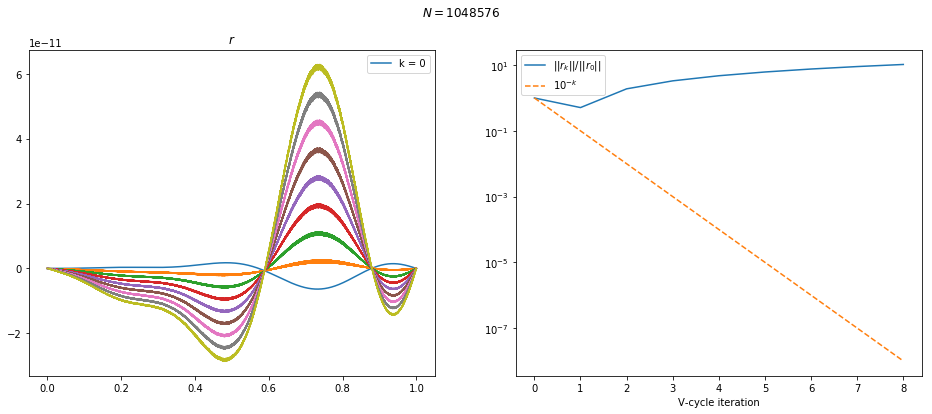

In [240]:
# Simple implementation of a multigrid method for the FDM discretization of the Poisson equation
# -u'' = b
import matplotlib.pyplot as plt
import numpy as np

def damped_jacobi(v, b, omega):
    v[1:-1] = (1. - omega) * v[1:-1] + omega * 0.5 * (b[1:-1] + v[:-2] + v[2:])

def jacobi23(v, b):
    damped_jacobi(v, b, 2. / 3.)


def restrict(v):
    """ Restriction operator. """
    return np.pad(0.25 * v[1:-3:2] + 0.5 * v[2:-2:2] + 0.25 * v[3:-1:2], 1, 'constant')

def prolong(v):
    """ Prolongation operator. """
    r = np.zeros(2 * len(v) - 1)
    r[::2] = v
    r[1::2] = 0.5 * (v[:-1] + v[1:])
    return r


def Amul(v):
    """ Multiplication by a dicrete Laplacian matrix. """
    return np.pad(-v[:-2] + 2. * v[1:-1] - v[2:], 1, 'constant')

def vcycle(v, b):
    """ One vcycle of a multigrid method. """
    if (len(v) - 1) & (len(v) - 2) != 0:
        raise ValueError("Lenth of v must be 2**n + 1.")
    
    N = len(v)-1
    h = 1. / N
    x = np.linspace(0., 1., N + 1)
    b = h**2 * (3. * (2 * np.sin(5.* np.pi * x) + 3* np.sin(2.* np.pi * x) + 0.5 * np.sin(np.pi * x))) * x**2
    b[0] = b[-1] = 0
    
    for i in range(3):
        jacobi23(v, b)

    if len(v) <= 3:
        return

    r = b - Amul(v)
    #r2 = 4. * restrict(r)
    r2 = restrict(r)

    e2 = np.zeros_like(r2)
    vcycle(e2, r2)
    v += prolong(e2)
    
    N = len(v)-1
    h = 1. / N
    x = np.linspace(0., 1., N + 1)
    b = h**2 * (3. * (2 * np.sin(5.* np.pi * x) + 3* np.sin(2.* np.pi * x) + 0.5 * np.sin(np.pi * x))) * x**2
    b[0] = b[-1] = 0
    
    for i in range(3):
        jacobi23(v, b)

# Testing

def tridiag_solver(b):
    """Tridiagonal matrix solver for the discrete Laplacian matrix, assuming the Dirichlet
    boundary condition x[0] = x[-1] = 0."""
    b = np.copy(b)
    v = np.zeros_like(b)
    c = np.zeros_like(b)

    for i in range(1, len(v) - 1):
        c[i] = -1. / (2 +  c[i - 1])
        b[i] = (b[i] + b[i - 1]) / (2 + c[i - 1])

    for i in reversed(range(1, len(v) - 1)):
        v[i] = b[i] - c[i] * v[i + 1]

    return v

def parameters(N):
    """ Initialize some test data. """
    h = 1. / N
    x = np.linspace(0., 1., N + 1)
    b = h**2 * (3. * (2 * np.sin(5.* np.pi * x) + 3* np.sin(2.* np.pi * x) + 0.5 * np.sin(np.pi * x))) * x**2
    b[0] = b[-1] = 0

    # "Exact" solution of the linear system.
    v_star = tridiag_solver(b)

    return x, b, v_star

N = 2**20 # Resolution of the test problem
x, b, v_star = parameters(N) # Initialize the test parameters

fig = plt.figure(figsize=(16, 6))
fig.suptitle('$N = {}$'.format(N))
plt.subplot(121, title = '$r$')

v = np.zeros_like(x)

r = b - Amul(v)
plt.plot(x, r, label = 'k = 0')
r_norm0 = np.sqrt(r.dot(r))
r_norm = [r_norm0]


for i in range(8):
    vcycle(v, b)

    r = b - Amul(v)
    r_norm.append(np.sqrt(r.dot(r)))
    plt.plot(x, r)


print(r_norm0, r_norm[0])
print(r_norm[0], r_norm[1])
print(r_norm[0]/r_norm[1])

plt.legend()
plt.subplot(122)
plt.semilogy(range(0, len(r_norm)), r_norm / r_norm0, label = r'$||r_k|| / ||r_0||$')
plt.semilogy(range(0, len(r_norm)), [10**(-k) for k in range(len(r_norm))], '--', label = r'$10^{-k}$')
plt.legend()
plt.xlabel('V-cycle iteration')


plt.show()


In [8]:
b = np.array([6., 25., -11., 15.])
v = np.zeros_like(b)

    
for i in range(100):
    print(v)
    damped_jacobi(v,b,1)


[0. 0. 0. 0.]
[ 0.  12.5 -5.5  0. ]
[0.   9.75 0.75 0.  ]
[ 0.    12.875 -0.625  0.   ]
[ 0.     12.1875  0.9375  0.    ]
[ 0.      12.96875  0.59375  0.     ]
[ 0.       12.796875  0.984375  0.      ]
[ 0.        12.9921875  0.8984375  0.       ]
[ 0.         12.94921875  0.99609375  0.        ]
[ 0.         12.99804688  0.97460938  0.        ]
[ 0.         12.98730469  0.99902344  0.        ]
[ 0.         12.99951172  0.99365234  0.        ]
[ 0.         12.99682617  0.99975586  0.        ]
[ 0.         12.99987793  0.99841309  0.        ]
[ 0.         12.99920654  0.99993896  0.        ]
[ 0.         12.99996948  0.99960327  0.        ]
[ 0.         12.99980164  0.99998474  0.        ]
[ 0.         12.99999237  0.99990082  0.        ]
[ 0.         12.99995041  0.99999619  0.        ]
[ 0.         12.99999809  0.9999752   0.        ]
[ 0.         12.9999876   0.99999905  0.        ]
[ 0.         12.99999952  0.9999938   0.        ]
[ 0.         12.9999969   0.99999976  0.        ]
[ 

In [7]:
import numpy as np

def jacobi(A, b):
    v = np.zeros_like(b)
    for k in range(1000):
        print('v_{:<4} = {}'.format(k, v))

        v_new = np.zeros_like(v)
        for i in range(A.shape[0]):
            s1 = A[i, :i].dot(v[:i])
            s2 = A[i, i + 1:].dot(v[i + 1:])
            v_new[i] = (b[i] - s1 - s2) / A[i, i]

        if np.max(np.abs(v - v_new)) < 1e-10:
            break
        v = v_new
    return v

A = np.array([[10., -1., 2., 0.],
              [-1., 11., -1., 3.],
              [2., -1., 10., -1.],
              [0.0, 3., -1., 8.]])
b = np.array([6., 25., -11., 15.])

v = jacobi(A, b)
print("Solution:", v)
print("Residual:", np.dot(A, v) - b)

v_0    = [0. 0. 0. 0.]
v_1    = [ 0.6         2.27272727 -1.1         1.875     ]
v_2    = [ 1.04727273  1.71590909 -0.80522727  0.88522727]
v_3    = [ 0.93263636  2.05330579 -1.04934091  1.13088068]
v_4    = [ 1.01519876  1.95369576 -0.96810863  0.97384272]
v_5    = [ 0.9889913   2.01141473 -1.0102859   1.02135051]
v_6    = [ 1.00319865  1.99224126 -0.99452174  0.99443374]
v_7    = [ 0.99812847  2.00230688 -1.00197223  1.00359431]
v_8    = [ 1.00062513  1.9986703  -0.99903558  0.99888839]
v_9    = [ 0.99967415  2.00044767 -1.00036916  1.00061919]
v_10   = [ 1.0001186   1.99976795 -0.99982814  0.99978598]
v_11   = [ 0.99994242  2.00008477 -1.00006833  1.0001085 ]
v_12   = [ 1.00002214  1.99995896 -0.99996916  0.99995967]
v_13   = [ 0.99998973  2.00001582 -1.00001257  1.00001924]
v_14   = [ 1.00000409  1.99999268 -0.99999444  0.9999925 ]
v_15   = [ 0.99999816  2.00000292 -1.0000023   1.00000344]
v_16   = [ 1.00000075  1.99999868 -0.99999899  0.99999862]
v_17   = [ 0.99999967  2.00000054

In [ ]:
# Simple implementation of a multigrid method for the FDM discretization of the Poisson equation
# -u'' = b
import matplotlib.pyplot as plt
import numpy as np

def damped_jacobi(v, b, omega):
    v[1:-1] = (1. - omega)*v[1:-1] + omega*0.5 * (b[1:-1] + v[:-2] + v[2:])

def jacobi23(v, b):
    damped_jacobi(v, b, 2. / 3.)


def restrict(v):
    return np.pad(0.25*v[1:-3:2] + 0.5*v[2:-2:2] + 0.25*v[3:-1:2], 1, 'constant')

def prolong(v):
    r = np.zeros(2 * len(v) - 1)
    r[::2] = v
    r[1::2] = 0.5 * (v[:-1] + v[1:])
    return r


def Amul(v):
    return np.pad(-v[:-2] + 2.* v[1:-1] - v[2:], 1, 'constant')

def vcycle(v, b):
    """ One vcycle of a multigrid method. """
    if (len(v) - 1) & (len(v) - 2) != 0:
        raise ValueError("Lenth of v must be 2**n + 1.")

    for i in range(3):
        jacobi23(v, b)

    if len(v) <= 3:
        return

    r = b - Amul(v)
    r2 = 4. * restrict(r)
    e2 = np.zeros_like(r2)
    vcycle(e2, r2)
    v += prolong(e2)

    for i in range(3):
        jacobi23(v, b)

# Testing

def tridiag_solver(b):
    """Tridiagonal matrix solver for the discrete Laplacian matrix, assuming the Dirichlet
    boundary condition x[0] = x[-1] = 0."""
    b = np.copy(b)
    v = np.zeros_like(b)
    c = np.zeros_like(b)

    for i in range(1, len(v) - 1):
        c[i] = -1. / (2 +  c[i - 1])
        b[i] = (b[i] + b[i - 1]) / (2 + c[i - 1])

    for i in reversed(range(1, len(v) - 1)):
        v[i] = b[i] - c[i] * v[i + 1]

    return v

def parameters(N):
    """ Initialize some test data. """
    h = 1. / N
    x = np.linspace(0., 1., N + 1)
    b = h**2 * (3. * (2 * np.sin(5.* np.pi * x) + 3* np.sin(2.* np.pi * x) + 0.5 * np.sin(np.pi * x))) * x**2
    b[0] = b[-1] = 0

    # "Exact" solution of the linear system.
    v_star = tridiag_solver(b)

    return x, b, v_star

N = 2**20 # Resolution of the test problem
x, b, v_star = parameters(N) # Initialize the test parameters

fig = plt.figure(figsize=(16, 6))
fig.suptitle('$N = {}$'.format(N))
plt.subplot(121, title = '$r$')

v = np.zeros_like(x)

r = b - Amul(v)
plt.plot(x, r, label = 'k = 0')
r_norm0 = np.sqrt(r.dot(r))
r_norm = [r_norm0]

for i in range(8):
    vcycle(v, b)

    r = b - Amul(v)
    r_norm.append(np.sqrt(r.dot(r)))
    plt.plot(x, r)


plt.legend()
plt.subplot(122)
plt.semilogy(range(0, len(r_norm)), r_norm / r_norm0, label = r'$||r_k|| / ||r_0||$')
plt.semilogy(range(0, len(r_norm)), [10**(-k) for k in range(len(r_norm))], '--', label = r'$10^{-k}$')
plt.legend()
plt.xlabel('V-cycle iteration')


plt.show()

In [224]:
a= np.linspace(0,10,21)
a[:-3:-1]

array([10. ,  9.5])

In [19]:
#1st part of #1
n=3
m=2
k=2
idx_arr_pos = np.array([(i*m)+(i*k) for i in range(1,n)])
idx_arr_neg = np.array([(i*m)-(i*k) for i in range(1,n)])
print(n)
print(idx_arr_pos, idx_arr_neg)
cos_arr_pos = np.cos(idx_arr_pos*np.pi/n)
cos_arr_neg = np.cos(idx_arr_neg*np.pi/n)
print(cos_arr_pos)
print(cos_arr_neg)
print(np.sum(cos_arr_pos), np.sum(cos_arr_neg))

3
[4 8] [0 0]
[-0.5 -0.5]
[1. 1.]
-0.9999999999999997 2.0


In [246]:
v = np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.,10.])
r = np.zeros(2*len(v) - 1)
r[::2] = v
r[1::2] = 0.5 * (v[:-1] + v[1:])
print(r)

[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10. ]
